In [1]:
from utils import * 
from tqdm import tqdm 
from src.vlr import * 

%load_ext autoreload
%autoreload 2

In [2]:
# get_vlr('black_borg.2_124', 'black_borg.2_372', metat_df)
# NOTE: Cannot compare the VLR of one pair to the VLR of another pair, but can compare VLR for the same pair across groups. 
# Can only be interpreted as a change in gene stoichiometry. 
# Significance is determined 

# Limited by the fact that we do not have true replicates, so probably will need to look at the depths together. Could be particularly 
# problematic considering the difference in mp_18. 

# What filter to use when computing VLR values? Doesn't make sense if the genes have no reads in all three samples, 
# or if both genes are zero in 2 of 3 samples. So need nonzero reads in a minimum of 2 samples. 

# This configuration could work to show they are not proportional if one is highly-expressed. High variance in log-ratios. 
# gene 1: (0 1 0) (0 0 0)
# gene 2: (0 0 0) (0 0 0)
# If all zero in one group because it's below the detection limit, it will give a false positive (i.e. false differential 
# proportionality between groups) because the variance in one group is zero in one group and nonzero in the other. 
# Maybe a super conservative filter would be a minimum count of 2 or 3 in 4 of the 6 samples?


In [5]:
# If stoichiometry does not change, value is closer to 1. So if in the same cluster, values should be closer to 1, 
# i.e. in the cluster that gets activated. Because I am using 1 - v, the genes with values closer to zero are in the same cluster. 
# Because transforming to a distance metric, values which are closer to zero indicate coordination. 
# Values closer to one indicate two different programs
# 







In [6]:
metat_df = metat_load()
metat_df = metat_df[(metat_df.reactor == 'n')].copy()

interproscan_df = load_interproscan().rename(columns={'id':'gene_id'})
interproscan_df = interproscan_df[interproscan_df.e_value < 1e-5].copy()

Num. genes passing the filter: 37
vlr_plot_diff: 905 values do not meet the p-value cutoff of 0.2


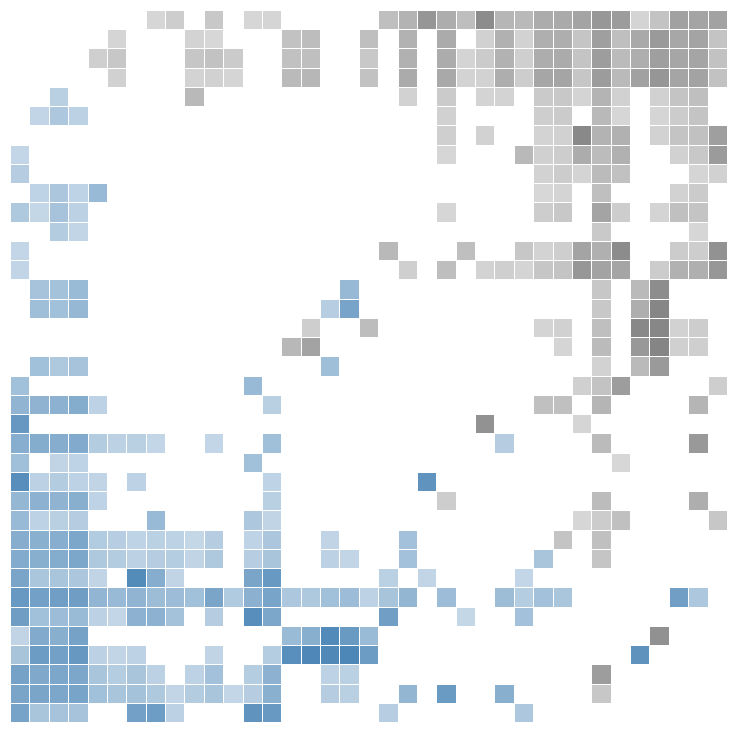

In [34]:
# I think what might be happening is the variance is higher in the samples with higher read counts, which is resulting in 
# a change in the variance in proportion that reflects primarily the gene abundance

genome_id = 'black_borg'
df = metat_df[metat_df.genome_id == genome_id].copy()
# df = metat_filter(df, threshold=5, min_samples=4)
df = metat_filter(df, threshold=2, min_samples=3)
df = metat_add_pseudocounts(df, method='mzr')
print('Num. genes passing the filter:', df.gene_id.nunique())
v_df, p_value_df = vlr_anova(df, method='disjoint', signed=True, weighted=False)

genbank_df = GenBankFile.from_file(f'../data/data/{genome_id}.gbk').to_df(clean_product=True)
genbank_df.index = [f'{genome_id}.{gene_id}' for gene_id in genbank_df.index]
annotations = genbank_df['product'].to_dict()

# Darker blue is closer to 1, lighter is closer to 0. 
vlr_plot_anova_heatmap(v_df, p_value_df=p_value_df, annotations=annotations, max_p_value=0.2, n_clusters=5, scale=0.25, ticks=False)

# Ratio between genes consistent in one of the two groups versus ratio between genes consistent in both groups, but 
# different ratios in each group. 

# High values of v_emergent enforce low values of v... How does this make sense? If the maximum of the two intra-group variances
# is small relative to total variance, then the inter-group variance must be high. 

# For emergent differential proportionality, values closer to zero imply that most of the overall variance can be explained by the 
# variance in one of the two treatment groups (i.e. proportionality in one of the two conditions). 
# Values closer to one imply that intra-group variance explains a small portion of the overall variance, which can mean low
# intra-group variance in both groups or high intra-group variance in both groups.  
# (1) coordinated expression or (2) highly-variable expression regardless of treatment group. 

# in the other group, they are not 

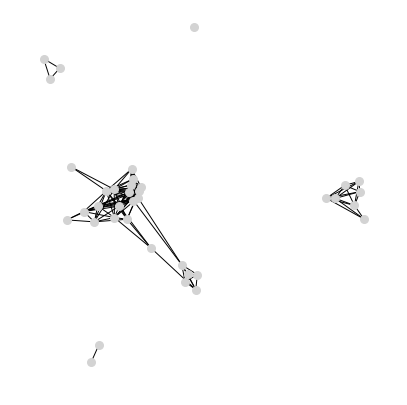

In [ ]:
vlr_get_graph(var_df, radius=15, plot=True)

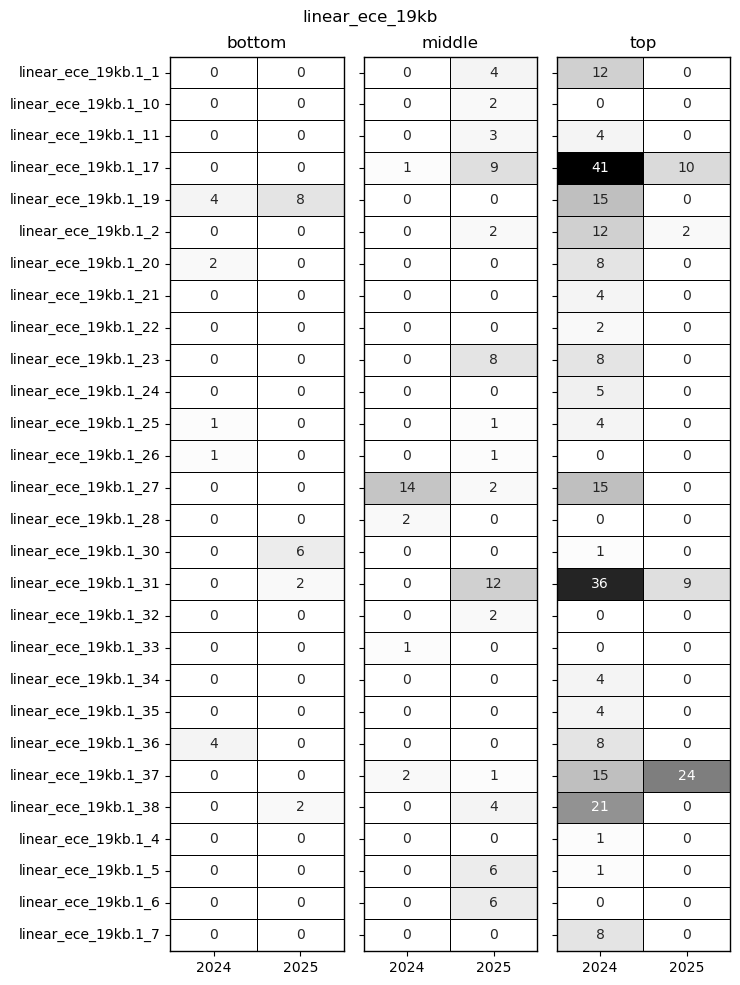

In [ ]:
def plot_ece_read_counts(genome_id:str, metat_df:pd.DataFrame=metat_df):
    figure_df = metat_df[metat_df.genome_id == genome_id].copy()
    read_counts = figure_df.groupby('gene_id').read_count.sum()
    figure_df = figure_df[figure_df.gene_id.isin(read_counts[read_counts > 0].index.values)]

    fig, axes = plt.subplots(figsize=(2.5 * 3, 10), ncols=3, sharey=True)
    v_min, v_max = figure_df.read_count.min(), figure_df.read_count.max()

    for ax, (location, df) in zip(axes, figure_df.groupby('location')):
        df = df.pivot(columns='year', index='gene_id', values='read_count')
        plot_read_counts(df, v_min=v_min, v_max=v_max, ax=ax, title=location)
    # axes[0].set_yticks(axes[0].get_yticks(), [figure_df[figure_df.gene_id == label.get_text()].annotation.iloc[0] for label in axes[0].get_yticklabels()])

    fig.suptitle(genome_id)
    fig.tight_layout()
    plt.show()

plot_ece_read_counts('linear_ece_19kb')

In [ ]:
capsid_gene_ids = ['black_borg.1_490', 'black_borg.1_491', 'black_borg.1_492', 'black_borg.1_493']
# Only one of these (corresponding to protein 801) actually resembles a capsid. 

annotations = dict()
annotations['black_borg.2_330'] = 'cytochrome C' # Annotation from ggKbase. 
annotations['black_borg.1_490'] = 'putative capsid-associated protein'
annotations['black_borg.2_258'] = 'blue (type1) copper domain-containing protein' # Annotation from ggKbase, InterProScan says cupredoxin, electron-tranfer amicyanin, 
annotations['black_borg.2_330'] = 'omcZ, cytochrome C, 8 heme-binding sites'
annotations['black_borg.2_155'] = 'S-layer-related duplication domain-containing protein'
annotations['black_borg.1_491'] = 'putative capsid-associated protein'
annotations['black_borg.1_492'] = 'putative capsid-associated protein'
annotations['black_borg.1_494'] = 'putative capsid-associated protein' # Must be in the same operon as the putative capsid protein. 
annotations['black_borg.2_124'] = 'hypothetical protein'
annotations['black_borg.4_3'] = 'hypothetical protein'
annotations['black_borg.2_175'] = 'hypothetical protein'
annotations['black_borg.2_259'] = 'putative multiheme cytochrome' # Weak hit. 
annotations['black_borg.2_372'] = 'ribonucleoprotein-like, TROVE domain-containing'
annotations['black_borg.1_556'] = 'DUF2173 domain-containing protein'
annotations['black_borg.1_493'] = 'putative capsid-associated protein'
annotations['black_borg.2_177'] = 'sialidase superfamily protein'
annotations['black_borg.3_29'] = 'type 3a cellulose-binding domain-containing protein'
annotations['black_borg.2_395'] = 'hypothetical protein'
annotations['black_borg.2_158'] = 'hypothetical protein'
annotations['black_borg.1_664'] = 'type 3a cellulose-binding domain-containing protein'

annotations['black_borg.1_478'] = 'hypothetical protein'
annotations['black_borg.2_191'] = 'chaperone protein DnaJ'
annotations['black_borg.2_241'] = 'hypothetical protein'
annotations['black_borg.1_548'] = 'hypothetical protein'
annotations['black_borg.2_384'] = 'DNA polymerase B'
annotations['black_borg.1_108'] = 'nucleotidyl transferase' # Adds nucleotides to the 3' end of nucleic acids. 
annotations['black_borg.1_107'] = 'hypothetical protein'
annotations['black_borg.1_241'] = 'hypothetical protein'
annotations['black_borg.1_535'] = 'hypothetical protein'
annotations['black_borg.1_432'] = 'hypothetical protein' # Has hits for G3DSA:2.60.120.260, seems possibly membrane-associated.
annotations['black_borg.2_29'] = 'dehalogenase-hydrolase'
annotations['black_borg.4_1'] = 'hypothetical protein'
annotations['black_borg.2_294'] = 'hypothetical protein'
annotations['black_borg.2_367'] = 'hypothetical protein'
annotations['black_borg.3_141'] = 'DNA polymerase B'
annotations['black_borg.4_3'] = 'hypothetical protein'

In [ ]:
def print_top_n_genes(genome_id:str, location:str='top', year:str='2025', n:int=20, annotations:dict={}):
    df = metat_df.sort_values('read_count', ascending=False)

    # kofamscan_df = KofamscanFile.from_file(f'../data/kofamscan/{genome_id}.txt').to_df()
    df = df[(df.year == year) & (df.genome_id == genome_id) & (df.location == location)].copy()
    total = df.read_count.sum()
    df = df.iloc[:n].copy()
    
    # df = df.merge(kofamscan_df, on='gene_id', how='left')
    # df = df.drop_duplicates(['gene_id', 'definition'])
    # df['definition'] = df.definition.fillna('')
    df['definition'] = [annotations.get(gene_id, 'hypothetical protein') for gene_id in df.gene_id]

    print(genome_id, end='\n\n')
    for i, row in enumerate(df.itertuples()):
        print(f'{i + 1}. {row.gene_id} {row.definition} {100 * row.read_count / total:.2f}%')
        # print(f"annotations['{row.gene_id}'] = ''")
    print(f'\nTotal explained: {100 * df.read_count.sum() / total:.2f}%')

print_top_n_genes('black_borg', year='2025', annotations=annotations)

# Black Borg contig 2 is scaffold_262
# Black Borg contig 1 is scaffold_129 
# Black Borg contig 4 is scaffold_851197
# Black Borg contig 3 is scaffold_2575

black_borg

1. black_borg.2_330 omcZ, cytochrome C, 8 heme-binding sites 8.24%
2. black_borg.1_490 putative capsid-associated protein 5.51%
3. black_borg.2_258 blue (type1) copper domain-containing protein 3.64%
4. black_borg.2_329 hypothetical protein 3.64%
5. black_borg.2_155 S-layer-related duplication domain-containing protein 3.10%
6. black_borg.1_491 putative capsid-associated protein 3.00%
7. black_borg.1_492 putative capsid-associated protein 2.89%
8. black_borg.2_124 hypothetical protein 2.73%
9. black_borg.1_494 putative capsid-associated protein 2.36%
10. black_borg.4_3 hypothetical protein 1.93%
11. black_borg.2_175 hypothetical protein 1.71%
12. black_borg.2_259 putative multiheme cytochrome 1.61%
13. black_borg.2_372 ribonucleoprotein-like, TROVE domain-containing 1.07%
14. black_borg.1_556 DUF2173 domain-containing protein 1.07%
15. black_borg.1_493 putative capsid-associated protein 1.02%
16. black_borg.2_177 sialidase superfamily protein 0.96%
17. black_borg.3_29 type 

In [ ]:


# def plot_rpkm_correlation(metat_df, gene_ids:list=None, ax=None, title:str='', log_scale:bool=False, genome_id='mp_18', threshold=10, min_samples=3, metric='geometric_mean'):
#     # Make sure to filter genome IDs before mzr. 
#     metat_df = metat_df[metat_df.genome_id == genome_id].copy()
#     metat_df = metat_filter(metat_df, threshold=threshold, min_samples=min_samples, field='read_count')
#     print('plot_rpkm_correlation: Num. genes passing the filter:', metat_df.gene_id.nunique())
#     metat_df = metat_add_pseudocounts(metat_df, method='mzr')

#     figure_df = metat_df[metat_df.gene_id.isin(gene_ids)].copy() if gene_ids is not None else metat_df.copy()

#     if metric == 'geometric_mean':
#         figure_df = figure_df.groupby(['sample_id', 'genome_id']).apply(lambda df : gmean(df.read_count.values), include_groups=False).reset_index(name='geometric_mean')
#     elif metric == 'median':
#         figure_df = figure_df.groupby(['sample_id', 'genome_id']).apply(lambda df : df.read_count.median(), include_groups=False).reset_index(name='median')

#     figure_df = figure_df.set_index(['sample_id', 'genome_id'])
#     figure_df['rpkm'] = metat_df.groupby(['sample_id', 'genome_id']).apply(lambda df : (df.read_count.sum() / (df.genome_size.sum() / 1e3) / (df.library_size.iloc[0] / 1e6)), include_groups=False)
#     figure_df = figure_df.reset_index(drop=False)
#     # print(f'plot_rpkm_correlation: Num instances with the mean rounding to zero for plot {title}: {(figure_df.geometric_mean == 0).sum()}')
#     if log_scale:
#         figure_df['rpkm'] = np.log10(figure_df.rpkm)
#         # figure_df['geometric_mean'] = np.log10(figure_df.geometric_mean)
#         figure_df[metric] = np.log10(figure_df[metric].values)

#     sns.scatterplot(figure_df, x='rpkm', y=metric, ax=ax, color='gray')


#     # result = pearsonr(figure_df.rpkm, figure_df.geometric_mean)
#     # m, b = np.polyfit(figure_df.rpkm, figure_df.geometric_mean, deg=1)

#     result = pearsonr(figure_df.rpkm, figure_df[metric])
#     m, b = np.polyfit(figure_df.rpkm, figure_df[metric], deg=1)
#     text = f'$R=${result.statistic:.2f}\n'
#     text += f'$p=${result.pvalue:.2f}\n'
#     text += fr'$\alpha=${m:.2f}' + '\n'
#     text += fr'$\beta=${b:.2f}'
#     ax.text(0.65, 0.25, text, transform=ax.transAxes)

#     ax.set_xlabel('activity'  if not log_scale else 'log$_{10}$(activity)')
#     metric = metric.replace('_', ' ')
#     ax.set_ylabel(metric if not log_scale else 'log$_{10}$' + f'({metric})')
#     ax.set_title(title)

#     return figure_df


# fig, axes = plt.subplots(figsize=(3 * 4, 3), ncols=4)

# metric = 'median'
# location = 'top'

# figure_df = metat_df[metat_df.location.isin(['middle', 'bottom', 'top'])].copy()
# plot_rpkm_correlation(figure_df, ax=axes[0], title='mp_18', log_scale=True, genome_id='mp_18', threshold=5, min_samples=2, metric=metric)
# plot_rpkm_correlation(figure_df, ax=axes[1], title='mp_16', log_scale=True, genome_id='mp_16', threshold=10, min_samples=3, metric=metric)
# plot_rpkm_correlation(figure_df, ax=axes[2], title='mp_4', log_scale=True, genome_id='mp_4', threshold=10, min_samples=3, metric=metric)
# plot_rpkm_correlation(figure_df, ax=axes[3], title='mp_20', log_scale=True, genome_id='mp_20', threshold=10, min_samples=3, metric=metric)


# fig.tight_layout()
# fig.suptitle(location)
# plt.show()
 

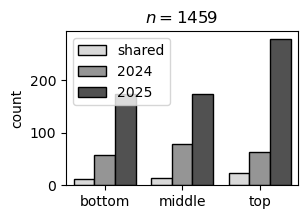

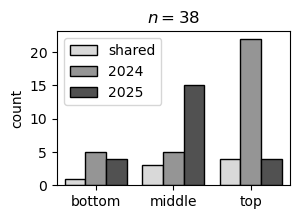

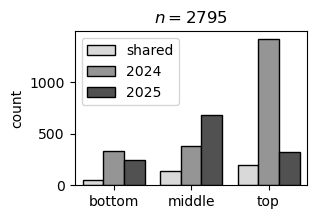

In [ ]:
def plot_detected_genes(metat_df, genome_id:str='linear_ece_19kb'):

    fig, ax = plt.subplots(figsize=(3, 2)) 

    get_n_shared_genes = lambda df : len(np.intersect1d(df[(df.year == '2024') & (df.read_count > 0)].gene_id.unique(), df[(df.year == '2025') & (df.read_count > 0)].gene_id.unique()))

    metat_df = metat_df[(metat_df.reactor == 'n') & (metat_df.genome_id == genome_id)].copy()

    figure_df = list()
    for location, df in metat_df.groupby('location'):
        figure_df.append({'category':'shared', 'n':get_n_shared_genes(df), 'location':location})
        figure_df.append({'category':'2024', 'n':((df.year == '2024') & (df.read_count > 0)).sum(), 'location':location})
        figure_df.append({'category':'2025', 'n':((df.year == '2025') & (df.read_count > 0)).sum(), 'location':location})
    figure_df = pd.DataFrame(figure_df)
    n_total = metat_df.gene_id.nunique()

    sns.barplot(figure_df, y='n', x='location', hue='category', palette='Grays', ax=ax, edgecolor='black')
    ax.set_xlabel('')
    ax.set_ylabel('count')
    ax.get_legend().set_title('')
    ax.set_title(f'$n={n_total}$')
    plt.show()

plot_detected_genes(metat_df, genome_id='black_borg')
plot_detected_genes(metat_df, genome_id='linear_ece_19kb')
plot_detected_genes(metat_df, genome_id='mp_18')

In [ ]:
annotations = dict()
annotations['linear_ece_19kb.1_'] = ''
annotations['linear_ece_19kb.1_2'] = 'unknown'
annotations['linear_ece_19kb.1_3'] = ''
annotations['linear_ece_19kb.1_4'] = ''
annotations['linear_ece_19kb.1_5'] = ''
annotations['linear_ece_19kb.1_'] = ''
annotations['linear_ece_19kb.1_'] = ''
annotations['linear_ece_19kb.1_'] = ''
annotations['linear_ece_19kb.1_'] = ''
annotations['linear_ece_19kb.1_'] = ''
annotations['linear_ece_19kb.1_'] = ''
annotations['linear_ece_19kb.1_'] = ''
annotations['linear_ece_19kb.1_'] = ''
annotations['linear_ece_19kb.1_'] = ''
annotations['linear_ece_19kb.1_'] = ''
annotations['linear_ece_19kb.1_'] = ''
annotations['linear_ece_19kb.1_17'] = 'single-stranded DNA binding protein, DUF669 '
annotations['linear_ece_19kb.1_22'] = 'unknown'
annotations['linear_ece_19kb.1_31'] = 'unknown'

# https://www.ebi.ac.uk/interpro/entry/InterPro/IPR014722/protein/UniProt/
# https://pmc.ncbi.nlm.nih.gov/articles/PMC3140696/ 
annotations['linear_ece_19kb.1_37'] = 'likely RNA-binding, maybe rRNA'
annotations['linear_ece_19kb.1_'] = ''

plot_read_counts: Dropping 28 genes with no presence in any sample.


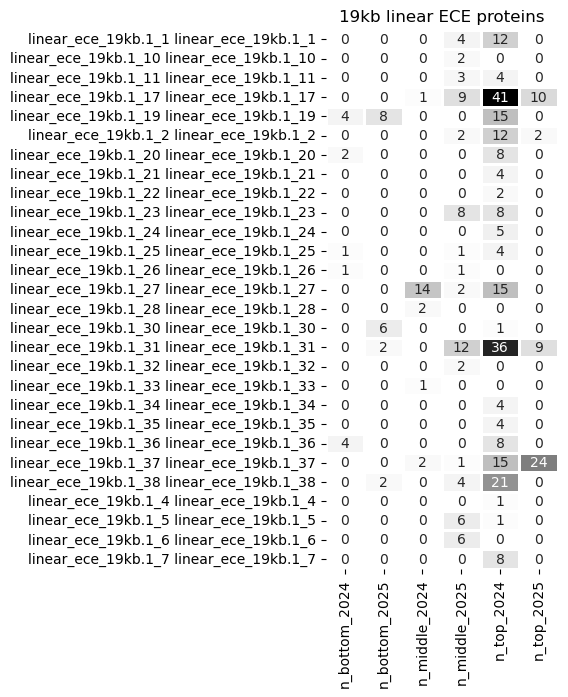

In [ ]:
# If we are looking for genes whose transcription is regulated differently than the background transcription of the putative host, it
# seems reasonable to normalize with respect to putative host mcrAB. 

linear_ece_19kb_metat_df = metat_df[metat_df.genome_id == 'linear_ece_19kb'].copy()
linear_ece_19kb_metat_df['annotation'] = linear_ece_19kb_metat_df.gene_id.copy()
plot_read_counts(linear_ece_19kb_metat_df, title='19kb linear ECE proteins', drop_empty=True, figsize=(3, 7))

In [ ]:
# Identify the potential capsid proteins on the Borgs. 
# subfam2354 and subfam1011 are profiled as viral capsid proteins, https://www.nature.com/articles/s41467-025-65646-7

# (1) BLACK-SR-VP_26_10_2019_C_40cm_scaffold_23_FINAvar_IR_801_BLACK-SR-VP_26_10_2019_C_40cm_scaffold_23_FINAvar_IR_SR-VP_26_10_2019_C_40cm___602689___603285___1_relaxed_rank_001_alphafold2_ptm_modevar_3_seed_000
# (2) BLACK-SR-VP_26_10_2019_C_40cm_scaffold_23_FINAvar_IR_283_relaxed_rank_001_alphafold2_ptm_modevar_3_seed_000
# (3) BLACK-SR-VP_26_10_2019_C_40cm_scaffold_23_FINAvar_IR_293_relaxed_rank_001_alphafold2_ptm_modevar_2_seed_000

# BLAST-aligned each of these sequences against the 2024 coassembly... 
# These are all on the second contig. 
# (1) SR-VP_05_06_2024_coassembly_scaffold_262_477 
# (2) SR-VP_05_06_2024_coassembly_scaffold_262_219
# (3) SR-VP_05_06_2024_coassembly_scaffold_262_209

# Confused because the paper marks the single jelly roll (SJR) major capsid protein as 801, and mentions high expression of 799, 800, and 801.
# Based on the spreadsheet, these are the following:
# (1) BLACK-SR-VP_26_10_2019_C_40cm_scaffold_23_FINAvar_IR_798_BLACK-SR-VP_26_10_2019_C_40cm_scaffold_23_FINAvar_IR_SR-VP_26_10_2019_C_40cm___601104___601415___1_relaxed_rank_001_alphafold2_ptm_modevar_4_seed_000
# (2) BLACK-SR-VP_26_10_2019_C_40cm_scaffold_23_FINAvar_IR_799_BLACK-SR-VP_26_10_2019_C_40cm_scaffold_23_FINAvar_IR_SR-VP_26_10_2019_C_40cm___601459___601776___1_relaxed_rank_001_alphafold2_ptm_modevar_3_seed_000
# (3) BLACK-SR-VP_26_10_2019_C_40cm_scaffold_23_FINAvar_IR_800_relaxed_rank_001_alphafold2_ptm_modevar_2_seed_000
# (4) BLACK-SR-VP_26_10_2019_C_40cm_scaffold_23_FINAvar_IR_801_BLACK-SR-VP_26_10_2019_C_40cm_scaffold_23_FINAvar_IR_SR-VP_26_10_2019_C_40cm___602689___603285___1_relaxed_rank_001_alphafold2_ptm_modevar_3_seed_000

# Which map to the following proteins in the coassembly, which are all on the first scaffold.:
# (1) SR-VP_05_06_2024_coassembly_scaffold_129_493
# (2) SR-VP_05_06_2024_coassembly_scaffold_129_492
# (3) SR-VP_05_06_2024_coassembly_scaffold_129_491
# (4) SR-VP_05_06_2024_coassembly_scaffold_129_490

capsid_gene_ids = ['black_borg.2_477', 'black_borg.2_219', 'black_borg.2_209']


In [ ]:
metat_df[metat_df.genome_id == 'black_borg'].contig_id.unique()

array(['black_borg.1', 'black_borg.2', 'black_borg.3', 'black_borg.4'],
      dtype=object)

plot_read_counts: Dropping 4 genes with no presence in any sample.


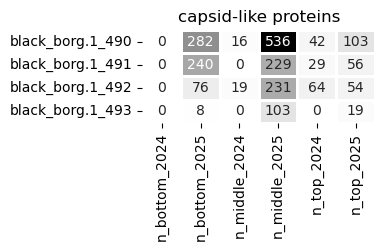

In [ ]:
plot_read_counts(metat_df[metat_df.gene_id.isin(capsid_gene_ids)].copy(), title='capsid-like proteins', figsize=(3, 1.2))

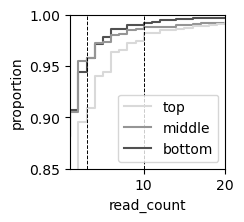

Total number of Black Borg genes: 1459
Total number of Black Borg genes detected in any sample: 573
Num. Black Borg genes in 2024 meeting the threshold: 60
Num. Black Borg genes in 2025 meeting the threshold: 56
Num. Black Borg genes meeting either threshold: 104


In [ ]:
# What are the distribution of mapped reads on the Black Borg across samples?

location = 'middle'
year = '2025'

fig, ax = plt.subplots(figsize=(2, 2))
# figure_df = metat_df[(metat_df.genome_id == 'black_borg') & (metat_df.location == location)].copy()
figure_df = metat_df[(metat_df.genome_id == 'black_borg') & (metat_df.year == year)].copy()
sns.ecdfplot(figure_df, hue='location', x='read_count', palette='Grays')
ax.set_xlim(xmin=1, xmax=20)
ax.set_ylim(ymin=0.85)
ax.get_legend().set_title('')
ax.axvline(10, color='black', ls='--', lw=0.7)
ax.axvline(3, color='black', ls='--', lw=0.7)
ax.set_ylabel('proportion')
plt.show()

# Transcriptional activity is so low in the 2024 samples, but we cannot make any assumptions about if these are "true zeros" because 
# it is possible that high coverage is due to extracellular ECEs. What might be the most valid is to look at genes that might have been highly-expressed in 
# 2024 versus those which were highly-expressed in 2025. I think the bottom sample might be completely useless. 
print('Total number of Black Borg genes:', metat_df[metat_df.genome_id == 'black_borg'].gene_id.nunique())
print('Total number of Black Borg genes detected in any sample:', metat_df[(metat_df.genome_id == 'black_borg') & (metat_df.read_count > 0)].gene_id.nunique())
threshold_2024 = 3 # Don't want to go lower because mapped reads of 1 or 2 feels too random and not reflective of any actual activity. 
threshold_2025 = 8

mask_2024 = (metat_df.genome_id == 'black_borg') & (metat_df.year == '2024') & (metat_df.read_count > threshold_2024)
mask_2025 = (metat_df.genome_id == 'black_borg') & (metat_df.year == '2025') & (metat_df.read_count > threshold_2025)

# Gene sets are almost completely orthogonal!
print('Num. Black Borg genes in 2024 meeting the threshold:', metat_df[mask_2024].gene_id.nunique())
print('Num. Black Borg genes in 2025 meeting the threshold:', metat_df[mask_2025].gene_id.nunique())
print('Num. Black Borg genes meeting either threshold:', metat_df[mask_2024 | mask_2025].gene_id.nunique())

In [ ]:
# black_borg_gene_ids = metat_df[mask_2024 | mask_2025].gene_id.unique()

diff_dfs = dict()
# I think I will need to do this on a sample-by-sample basis. 
for location, df in metat_df[metat_df.genome_id == 'black_borg'].groupby('location'):
    mask = ((df.year == '2024') & (df.read_count > threshold_2024))
    mask = mask | ((df.year == '2025') & (df.read_count > threshold_2025))
    gene_ids = df[mask].gene_id.unique()
    print(f'Num. genes in {location} passing the detection cutoffs:', len(gene_ids))
    diff_dfs[location] = metat_get_diff(df[df.gene_id.isin(gene_ids)].copy(), threshold=0, normalization='clr', location=location, genome_id='black_borg')

Num. genes in bottom passing the detection cutoffs: 24
Num. genes in middle passing the detection cutoffs: 46
Num. genes in top passing the detection cutoffs: 60


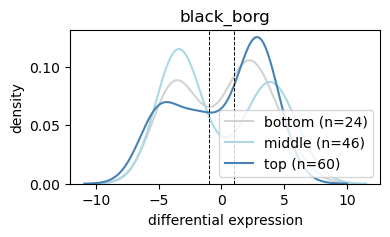

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2))

palette = {'bottom':'lightgray', 'middle':'lightblue', 'top':'steelblue'}
for location, df in diff_dfs.items():
    sns.kdeplot(df, x='diff', color=palette[location], label=f'{location} (n={len(df)})')

ax.set_ylabel('density')
ax.set_xlabel('differential expression')
ax.set_title('black_borg')
ax.axvline(1, ls='--', color='black', lw=0.7)
ax.axvline(-1, ls='--', color='black', lw=0.7)
ax.legend(loc='lower right')

plt.show()
# Basically amounts to assessing how orthogonal each set of genes is


In [ ]:
location = 'top'

diff_df = diff_dfs[location]
diff_df = diff_df[diff_df['diff'] > 1].copy()
diff_df = diff_df.merge(interproscan_df.drop(columns=['genome_id']), on='gene_id', how='left')
print('Num. genes meeting threshold:', diff_df.gene_id.nunique())
print('Num. with no annotation:', diff_df[diff_df.signature_accession.isnull()].gene_id.nunique())
print('Num. with an InterPro description:', diff_df[(diff_df.interpro_description != '-') & (~diff_df.interpro_accession.isnull())].gene_id.nunique(), end='\n\n')

# for hmm, df in diff_df.groupby('signature_analysis', observed=True):
#     print(f'Num. with a {hmm} annotation:', df.gene_id.nunique())
diff_df = diff_df[['gene_id', 'location', 'diff', 'interpro_accession', 'interpro_description']].copy()
diff_df = diff_df.rename(columns={'interpro_accession':'accession', 'interpro_description':'annotation'})
diff_df = diff_df.drop_duplicates(['gene_id', 'accession'])
diff_df = diff_df[(diff_df.accession != '-') & (~diff_df.accession.isnull())].copy()

Num. genes meeting threshold: 29
Num. with no annotation: 9
Num. with an InterPro description: 19



In [ ]:
for gene_id, df in diff_df.groupby('gene_id'):
    # print(f"annotations['top']['{gene_id}'] = ''")
    print(gene_id)
    print('\n'.join(df[~df.annotation.isnull()].annotation))
    print()

black_borg.1_109
Nucleophile aminohydrolases, N-terminal
SIS domain
SIS domain superfamily
Glucosamine-fructose-6-phosphate aminotransferase, isomerising
GlmS/FrlB, SIS domain 2
Glucosamine-fructose-6-phosphate aminotransferase, isomerising, N-terminal domain
GlmS/AgaS, SIS domain 1

black_borg.1_13
Immunoglobulin-like fold
von Willebrand factor A-like domain superfamily
Spermadhesin, CUB domain superfamily
von Willebrand factor, type A
Invasin/intimin cell-adhesion fragments
Calcium-activated chloride channel regulator
CUB domain

black_borg.1_167
Adenine-specific methyltransferase, domain 2
S-adenosyl-L-methionine-dependent methyltransferase superfamily
D12 class N6 adenine-specific DNA methyltransferase
Adenine modification methylase, M.EcoRV-type

black_borg.1_178
Tubulin/FtsZ, GTPase domain superfamily

black_borg.1_410
Histidine kinase/HSP90-like ATPase superfamily
Histidine kinase/HSP90-like ATPase domain
PAS domain
Signal transduction response regulator, receiver domain
Signal 

In [ ]:
# Genes up-regulated in the top sample (part of the 2025 spike)
annotations = dict()

annotations['top'] = dict()
# 

# Glucosamine-fructose-6-phosphate aminotransferase catalyses the first reaction in hexamine biosynthesis. It belongs to an 
# F-type group of glutamine-dependent amidotransferase family of enzymes, which utilise the glutamine amide nitrogen in the 
# biosynthesis of phosphoribosylamine, glutamate or asparagine. 
annotations['top']['black_borg.1_109'] = 'glucosamine-fructose-6-phosphate aminotransferase'
annotations['top']['black_borg.1_13'] = 'von Willebrand factor type A domain-containing protein, invasin/intimin cell-adhesion fragments'
annotations['top']['black_borg.1_167'] = 'adenine modification methylase'
annotations['top']['black_borg.1_178'] = 'tubulin/FtsZ GTPase domain-containing protein'
annotations['top']['black_borg.1_410'] = 'histidine kinase, HSP90-like'
annotations['top']['black_borg.1_556'] = 'DUF2173 domain-containing protein'
annotations['top']['black_borg.1_631'] = 'arsenical pump ATPase'
# Apparently associated with cellusomes and carbohydrate/polysaccharide degradation. 
annotations['top']['black_borg.1_664'] = 'CBM2/CBM3 carbohydrate-binding domain'
# https://www.cell.com/iscience/fulltext/S2589-0042(21)01039-7
# Probably involved in cellular adhesion. 
annotations['top']['black_borg.2_125'] = 'polysaccharide deacetylase'
annotations['top']['black_borg.2_150'] = 'xyloglucan-specific glycosyl hydrolase'
annotations['top']['black_borg.2_177'] = 'sialidase'
annotations['top']['black_borg.2_317'] = ''
annotations['top']['black_borg.2_329'] = ''
annotations['top']['black_borg.2_330'] = ''
annotations['top']['black_borg.2_372'] = ''
annotations['top']['black_borg.2_40'] = ''
annotations['top']['black_borg.2_433'] = ''
annotations['top']['black_borg.3_13'] = ''
annotations['top']['black_borg.3_29'] = ''

,gene_id,location,diff,accession,annotation
2,black_borg.1_109,top,2.563049,IPR029055,"Nucleophile aminohydrolases, N-terminal"
4,black_borg.1_109,top,2.563049,IPR001347,SIS domain
7,black_borg.1_109,top,2.563049,IPR046348,SIS domain superfamily
11,black_borg.1_109,top,2.563049,IPR005855,Glucosamine-fructose-6-phosphate aminotransfer...
13,black_borg.1_109,top,2.563049,IPR035490,"GlmS/FrlB, SIS domain 2"
...,...,...,...,...,...
146,black_borg.2_433,top,2.668409,IPR046357,Peptidyl-prolyl cis-trans isomerase domain sup...
147,black_borg.2_433,top,2.668409,IPR001179,FKBP-type peptidyl-prolyl cis-trans isomerase ...
151,black_borg.3_13,top,2.850731,IPR014721,Small ribosomal subunit protein uS5 domain 2-t...
152,black_borg.3_13,top,2.850731,IPR020568,Ribosomal protein uS5 domain 2-type superfamily


In [ ]:
# interproscan_df[interproscan_df.signature_description.str.contains('capsid|coat|phage|DNA polymerase|histone', case=False) & (interproscan_df.genome_id == 'black_borg')]
interproscan_df[interproscan_df.signature_description.str.contains('histone|packaging', case=False) & (interproscan_df.genome_id == 'black_borg')]

,gene_id,md5,length,signature_analysis,signature_accession,signature_description,start,stop,e_value,status,date,interpro_accession,interpro_description,genome_id
2446,black_borg.1_104,baf07dc78604582470669976b82621fb,76,Gene3D,G3DSA:1.10.20.10,Histone-fold,9,73,6.900000e-21,T,02-01-2026,IPR009072,Histone-fold,black_borg
2444,black_borg.1_104,baf07dc78604582470669976b82621fb,76,Pfam,PF00808,Transcription factor CBF/NF-Y/archaeal histone...,9,70,1.900000e-13,T,02-01-2026,IPR003958,Transcription factor CBF/NF-Y/archaeal histone...,black_borg
2445,black_borg.1_104,baf07dc78604582470669976b82621fb,76,SUPERFAMILY,SSF47113,Histone-fold,7,73,1.410000e-17,T,02-01-2026,IPR009072,Histone-fold,black_borg
2447,black_borg.1_104,baf07dc78604582470669976b82621fb,76,PANTHER,PTHR47828,Archaeal histone HMF,8,73,1.000000e-24,T,02-01-2026,IPR050947,Archaeal histone HMF,black_borg


In [ ]:
#  subfam2354 subfam1011